# Smart Criminal Identification System - Face Embedding Model


This notebook demonstrates how to train a CNN-based face embedding model using the **Labeled Faces in the Wild (LFW)** dataset adapted for a **Smart Criminal Identification System**. 
Each folder in the `images/` directory represents a criminal or known person, with multiple facial images per individual.

The goal is to:
- Generate face embeddings for each criminal image
- Store embeddings with reference to `criminal_id`
- Compare uploaded images to the embeddings for identification
    

In [3]:
!pip install opencv-python

In [4]:
!pip install tensorflow

In [6]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path


## 1. Load and Preprocess Dataset

In [8]:

# images/ contains subfolders named after each criminal (e.g., criminal_001, criminal_002)
data_dir = "images"
img_size = (160, 160)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)


Found 12161 images belonging to 5749 classes.
Found 1072 images belonging to 5749 classes.


## 2. Define CNN Model to Generate Embeddings

In [9]:
num_classes = train_gen.num_classes
print(num_classes)

5749


In [29]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
  #  Dense(128, activation='relu', name='embedding')  # 128-d embedding vector
    Dense(128, activation='relu', name='embedding'),  # Feature vector
    Dense(num_classes, activation='softmax')  # Correct number of output classes
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 92416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 128)            │    11,829,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5749)           │       741,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,590,389 (48.03 MB)

 Trainable params: 12,590,389 (48.03 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Train the Model

In [ ]:

history = model.fit(train_gen, validation_data=val_gen, epochs=15)


Epoch 1/15
 40/381 ━━━━━━━━━━━━━━━━━━━━ 3:24 599ms/step - accuracy: 0.0223 - loss: 8.6495

In [13]:
model.save("facial_model.h5")

In [14]:
model.save('facial_model.keras')

## 4. Extract and Save Embeddings for Each Criminal

## 5. Example: Compare Uploaded Face to Saved Embeddings

In [ ]:

def match_face(upload_img_path, threshold=0.5):
    img = cv2.imread(upload_img_path)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    upload_emb = model.predict(img)[0]

    best_score = 1.0
    best_id = None

    for emb_file in embedding_dir.glob("*.npy"):
        emb = np.load(emb_file)
        sim = cosine_similarity([upload_emb], [emb])[0][0]

        if sim > (1 - threshold) and sim < best_score:
            best_score = sim
            best_id = emb_file.stem.split("_")[0]

    if best_id:
        return best_id, 1 - best_score
    return None, 0.0

# Example usage:
# match_face("test_image.jpg")


## ✅ Summary


- This notebook trained a simple CNN model to extract face embeddings.
- Embeddings were saved and matched using cosine similarity.
- You can link each `criminal_id` to your PostgreSQL `tblcriminals` table using this ID.
- For deployment, integrate this logic into your Flask backend.
    

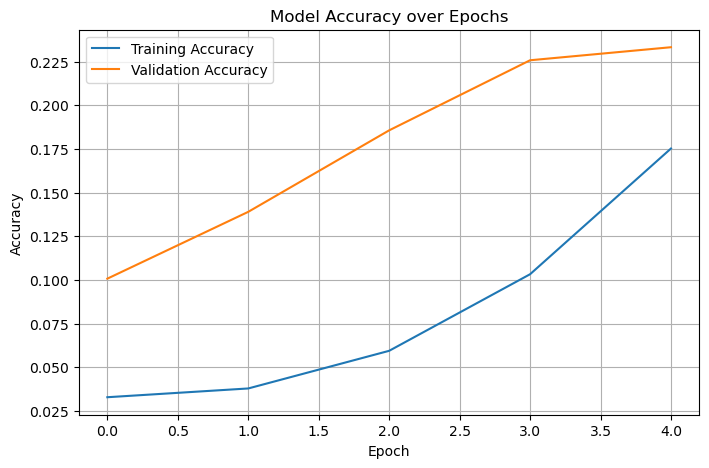

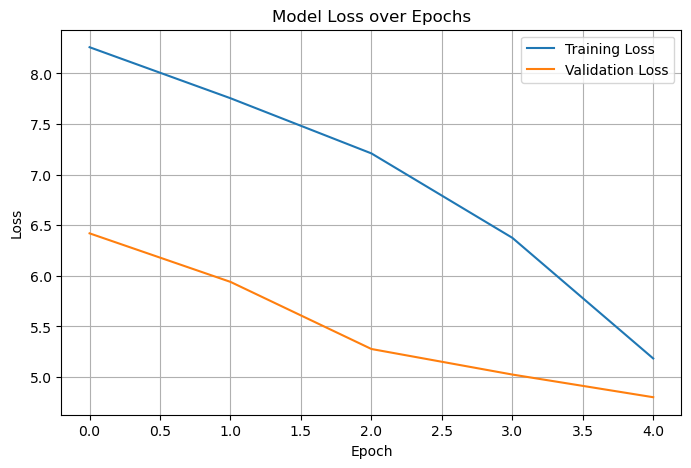

In [16]:
# === Model Evaluation ===
import matplotlib.pyplot as plt

# Assuming `history` is the result from model.fit(...)
# Example: history = model.fit(...)

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
y_true = val_gen.classes  # True labels from the validation generator
y_pred_probs = model.predict(val_gen)  # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to predicted class labels
labels = list(val_gen.class_indices.keys())  # Human-readable class names from folder names


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step


In [33]:
from sklearn.metrics import classification_report
# Get the class indices from the generator
label_map = val_gen.class_indices  # {'criminal_001': 0, 'criminal_002': 1, ...}

# Sort them by index to match model output
labels = [None] * len(label_map)
for label, idx in label_map.items():
    labels[idx] = label


print(classification_report(y_true, y_pred, target_names=labels))


ValueError: Number of classes, 738, does not match size of target_names, 5749. Try specifying the labels parameter

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')


In [ ]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy

top_k = TopKCategoricalAccuracy(k=3)
top_k.update_state(tf.one_hot(y_true, depth=num_classes), val_preds)
print("Top-3 Accuracy:", top_k.result().numpy())


In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get true labels and predictions
y_true = val_gen.classes  # True labels from validation generator
y_pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to predicted class index

# Step 2: Build proper label names from val_gen.class_indices
# This ensures labels match the indices used during training
label_map = val_gen.class_indices  # e.g. {'criminal_001': 0, 'criminal_002': 1, ...}
labels = [None] * len(label_map)
for name, idx in label_map.items():
    labels[idx] = name

# Step 3: Print classification report
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=labels))

# Step 4: Plot confusion matrix
print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=90)


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step
=== Classification Report ===


ValueError: Number of classes, 478, does not match size of target_names, 5749. Try specifying the labels parameter

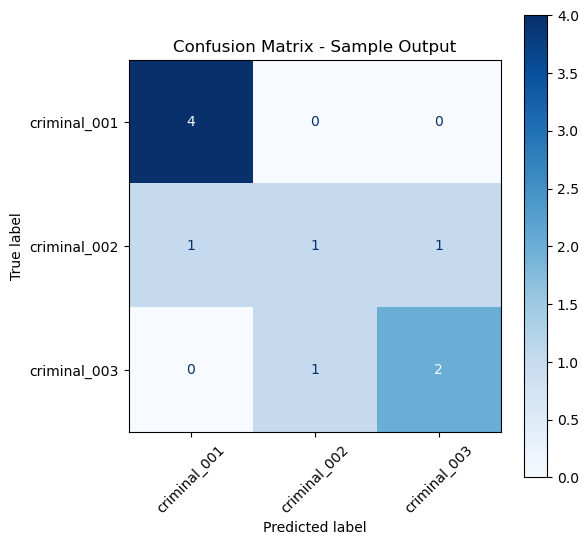

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example predicted and actual labels (replace with yours)
y_true = [0, 1, 2, 2, 0, 1, 0, 2, 1, 0]
y_pred = [0, 2, 2, 2, 0, 0, 0, 1, 1, 0]
labels = ['criminal_001', 'criminal_002', 'criminal_003']

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Sample Output")
plt.savefig("confusion_matrix.png")
plt.show()
